In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt

In [96]:
stocks = 'MSFT'
start_day = datetime.datetime(2010, 1, 1)
end_day = datetime.datetime(2022, 11, 1)
sp500 = yf.download(stocks, start=start_day, end=end_day, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [97]:
ret = 100*(sp500.pct_change()[1:]['Adj Close'])
realized_vol = ret.rolling(5).std()

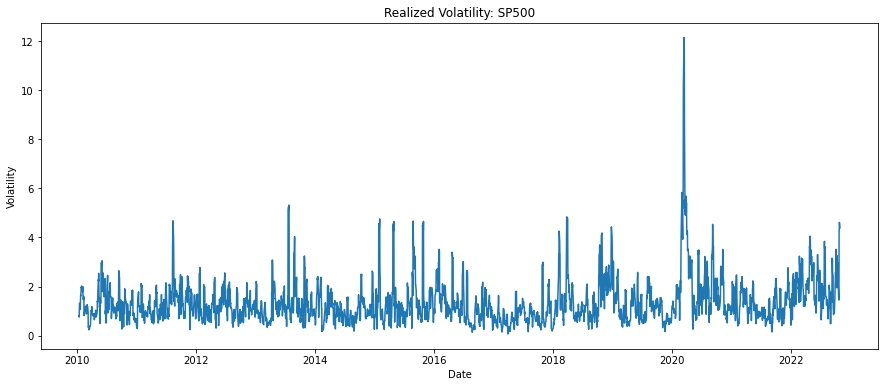

In [98]:
plt.figure(figsize=(15,6))
plt.plot(realized_vol.index, realized_vol)
plt.title('Realized Volatility: SP500')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [99]:
ret_vals = ret.values

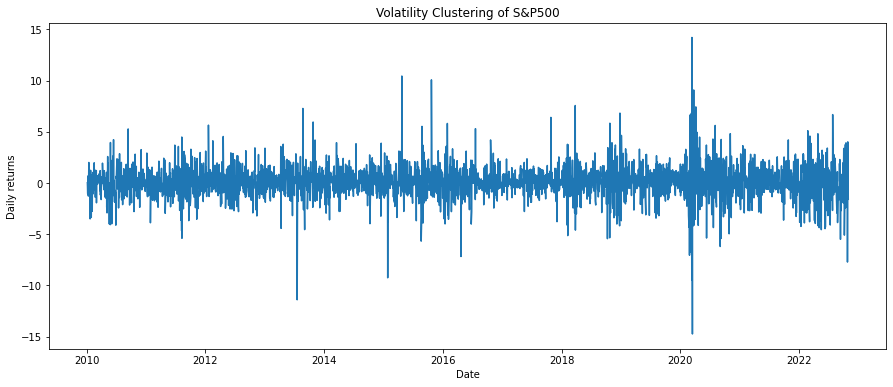

In [100]:
plt.figure(figsize=(15, 6))
plt.plot(sp500.index[1:], ret)
plt.title('Volatility Clustering of S&P500')
plt.ylabel('Daily returns')
plt.xlabel('Date')
plt.show()

In [101]:
n = 252
split_date = ret.iloc[-n:].index

In [102]:
arch = arch_model(ret, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5981.90
Distribution:                  Normal   AIC:                           11967.8
Method:            Maximum Likelihood   BIC:                           11980.0
                                        No. Observations:                 3229
Date:                Fri, Nov 04 2022   Df Residuals:                     3229
Time:                        22:46:05   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.8741      0.122     15.417  1.267e-53 [  1.636,  2.11

In [103]:
bic_arch = []
best_param = None
for p in range(1, 5):
    arch = arch_model(ret, mean='zero', vol='ARCH', p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic <= np.min(bic_arch):
        best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5897.75
Distribution:                  Normal   AIC:                           11805.5
Method:            Maximum Likelihood   BIC:                           11835.9
                                        No. Observations:                 3229
Date:                Fri, Nov 04 2022   Df Residuals:                     3229
Time:                        22:46:08   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.2782      0.122     10.487  9.874e-26    [  

In [104]:
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

/opt/miniconda3/envs/py38quant/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [105]:
from sklearn.metrics import mean_squared_error as mse

In [106]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100,
                       np.sqrt(forecast_arch.variance.iloc[-len(split_date):]/100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.1701


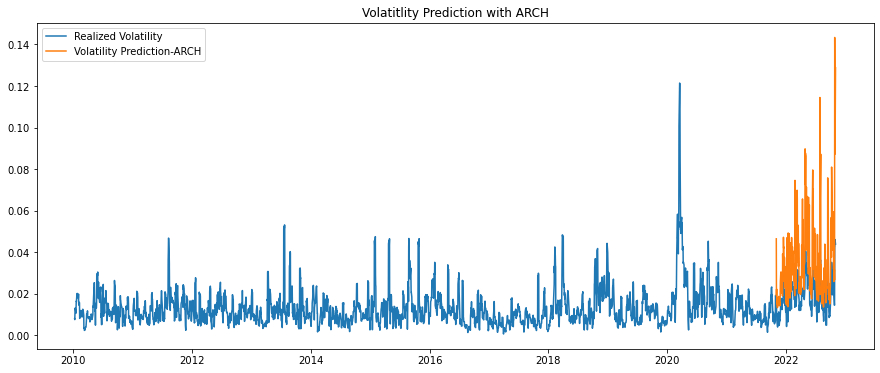

In [107]:
plt.figure(figsize=(15, 6))
plt.plot(realized_vol/100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100,
        label='Volatility Prediction-ARCH')
plt.title('Volatitlity Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

# GARCH

In [108]:
garch = arch_model(ret, mean='zero', vol='GARCH', p=1, o=0, q=1).fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5869.95
Distribution:                  Normal   AIC:                           11745.9
Method:            Maximum Likelihood   BIC:                           11764.1
                                        No. Observations:                 3229
Date:                Fri, Nov 04 2022   Df Residuals:                     3229
Time:                        22:46:17   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2256  7.968e-02      2.831  4.641e-03 [6.939e-0

In [109]:
bic_arch = []
best_param = None
for p in range(1, 5):
    for q in range(1, 5):
        arch = arch_model(ret, mean='zero', vol='GARCH', p=p, o=0, q=q).fit(disp='off')
        bic_arch.append(arch.bic)
        if arch.bic <= np.min(bic_arch):
            best_param = (p, q)
garch = arch_model(ret, mean='zero', vol='GARCH', p=best_param[0], o=0, q=best_param[1]).fit(disp='off')
print(garch.summary())

forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5869.95
Distribution:                  Normal   AIC:                           11745.9
Method:            Maximum Likelihood   BIC:                           11764.1
                                        No. Observations:                 3229
Date:                Fri, Nov 04 2022   Df Residuals:                     3229
Time:                        22:46:19   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2256  7.968e-02      2.831  4.641e-03 [6.939e-0

/opt/miniconda3/envs/py38quant/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [110]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                       np.sqrt(forecast_garch.variance.iloc[-len(split_date):]/100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of ARCH model is 0.1713


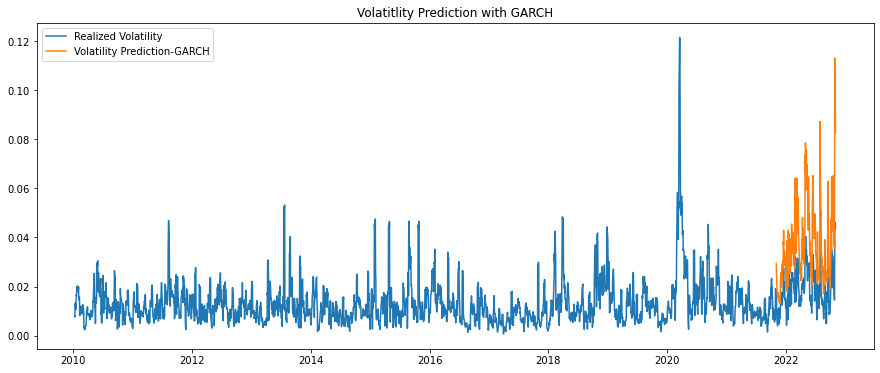

In [111]:
plt.figure(figsize=(15, 6))
plt.plot(realized_vol/100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100,
        label='Volatility Prediction-GARCH')
plt.title('Volatitlity Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

# SVR-GARCH

In [112]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [113]:
ret_svm = ret**2
ret_svm = pd.DataFrame(ret_svm)
ret_svm.reset_index(drop=True, inplace=True)

In [114]:
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

In [115]:
X = pd.concat([realized_vol, ret_svm], axis=1, ignore_index=True)

In [116]:
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

In [117]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

In [118]:
print(X.size, realized_vol.size)

6450 3225


In [119]:
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

## SVR(Lin)-GARCH

In [120]:
para_grid = {'gamma': sp_rand(),
                'C': sp_rand(),
            'epsilon': sp_rand()}

clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values,
       realized_vol[1:-(n-1)].values.reshape(-1))

RandomizedSearchCV(estimator=SVR(kernel='linear'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fd77a756670>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fd7835e8700>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fd7835f7a60>})

In [121]:
pred_svr_lin = clf.predict(X.iloc[-n:])
pred_svr_lin = pd.DataFrame(pred_svr_lin)
pred_svr_lin.index = ret.iloc[-n:].index

In [122]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                                    pred_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}' .format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.001411


In [123]:
realized_vol.index = ret.iloc[4:].index

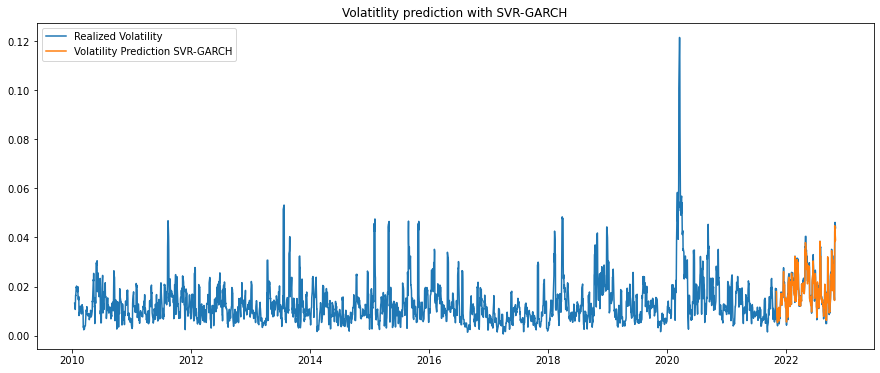

In [124]:
plt.figure(figsize=(15, 6))
plt.plot(realized_vol[4:]/100, label = 'Realized Volatility')
plt.plot(pred_svr_lin/100, label = 'Volatility Prediction SVR-GARCH')
plt.title('Volatitlity prediction with SVR-GARCH', fontsize=12)
plt.legend()
plt.show()

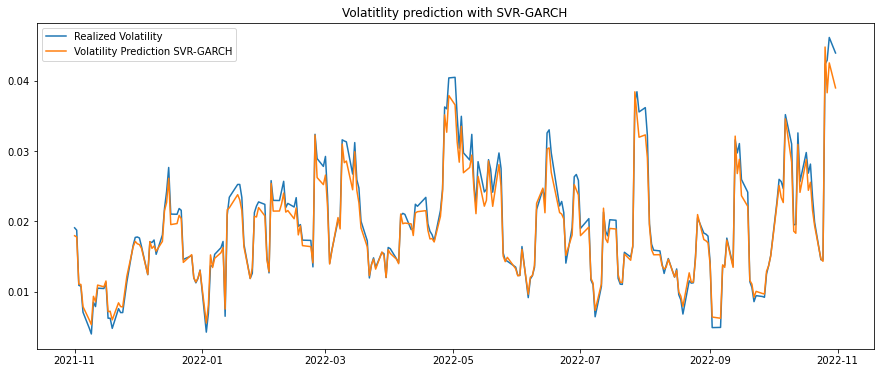

In [125]:
plt.figure(figsize=(15, 6))
plt.plot(realized_vol[-pred_svr_lin.size:]/100, label = 'Realized Volatility')
plt.plot(pred_svr_lin/100, label = 'Volatility Prediction SVR-GARCH')
plt.title('Volatitlity prediction with SVR-GARCH', fontsize=12)
plt.legend()
plt.show()

## SVR(RBF)-GARCH

In [126]:
para_grid = {'gamma': sp_rand(),
                'C': sp_rand(),
            'epsilon': sp_rand()}

clf = RandomizedSearchCV(svr_rbf, para_grid)
clf.fit(X.iloc[:-n].values,
       realized_vol[1:-(n-1)].values.reshape(-1))

pred_svr_rbf = clf.predict(X.iloc[-n:])
pred_svr_rbf = pd.DataFrame(pred_svr_rbf)
pred_svr_rbf.index = ret.iloc[-n:].index

In [127]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                                    pred_svr_rbf / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}' .format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.001560


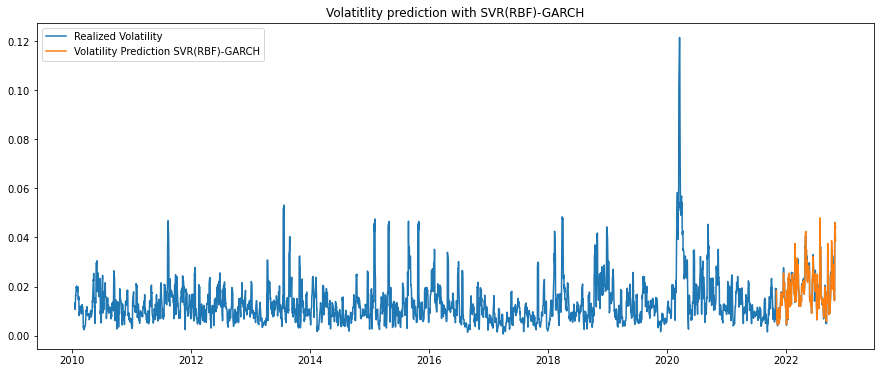

In [128]:
realized_vol.index = ret.iloc[4:].index
plt.figure(figsize=(15, 6))
plt.plot(realized_vol[4:]/100, label = 'Realized Volatility')
plt.plot(pred_svr_rbf/100, label = 'Volatility Prediction SVR(RBF)-GARCH')
plt.title('Volatitlity prediction with SVR(RBF)-GARCH', fontsize=12)
plt.legend()
plt.show()

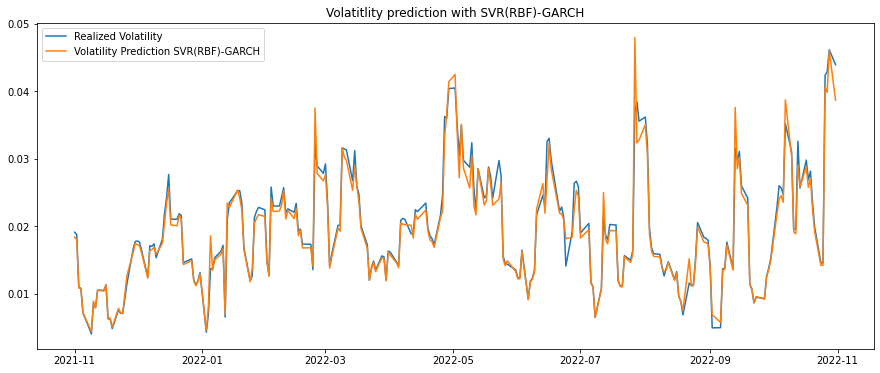

In [129]:
realized_vol.index = ret.iloc[4:].index
plt.figure(figsize=(15, 6))
plt.plot(realized_vol[-pred_svr_rbf.size:]/100, label = 'Realized Volatility')
plt.plot(pred_svr_rbf/100, label = 'Volatility Prediction SVR(RBF)-GARCH')
plt.title('Volatitlity prediction with SVR(RBF)-GARCH', fontsize=12)
plt.legend()
plt.show()

## Gaussian process

In [130]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [131]:
kernel = DotProduct() + WhiteKernel()
clf = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X.iloc[:-n].values,
       realized_vol[1:-(n-1)].values.reshape(-1))

In [132]:
pred_gp, var = clf.predict(X.iloc[-n:], return_std=True)
pred_gp = pd.DataFrame(pred_gp)
pred_gp.index = ret.iloc[-n:].index

In [133]:
rmse_gp = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                                    pred_gp / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}' .format(rmse_gp))

The RMSE value of SVR with Linear Kernel is 0.001666


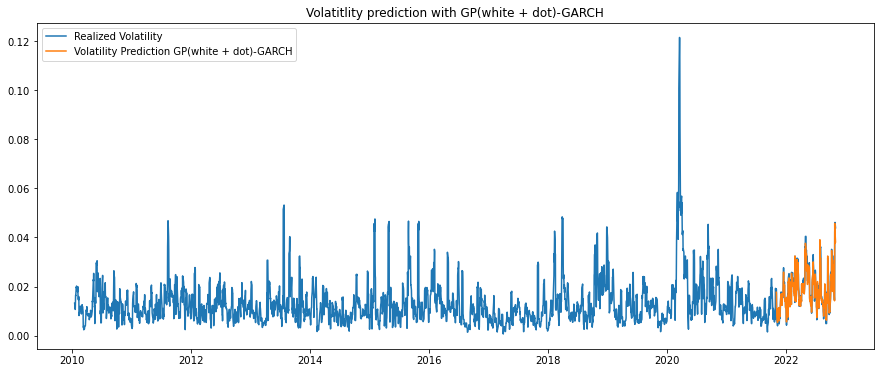

In [134]:
realized_vol.index = ret.iloc[4:].index
plt.figure(figsize=(15, 6))
plt.plot(realized_vol[4:]/100, label = 'Realized Volatility')
plt.plot(pred_gp/100, label = 'Volatility Prediction GP(white + dot)-GARCH')
plt.title('Volatitlity prediction with GP(white + dot)-GARCH', fontsize=12)
plt.legend()
plt.show()

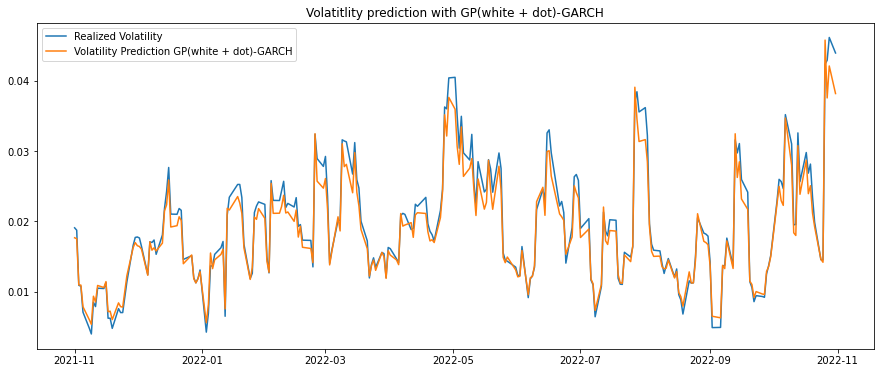

In [135]:
realized_vol.index = ret.iloc[4:].index
plt.figure(figsize=(15, 6))
plt.plot(realized_vol[-pred_gp.size:]/100, label = 'Realized Volatility')
plt.plot(pred_gp/100, label = 'Volatility Prediction GP(white + dot)-GARCH')
plt.title('Volatitlity prediction with GP(white + dot)-GARCH', fontsize=12)
plt.legend()
plt.show()

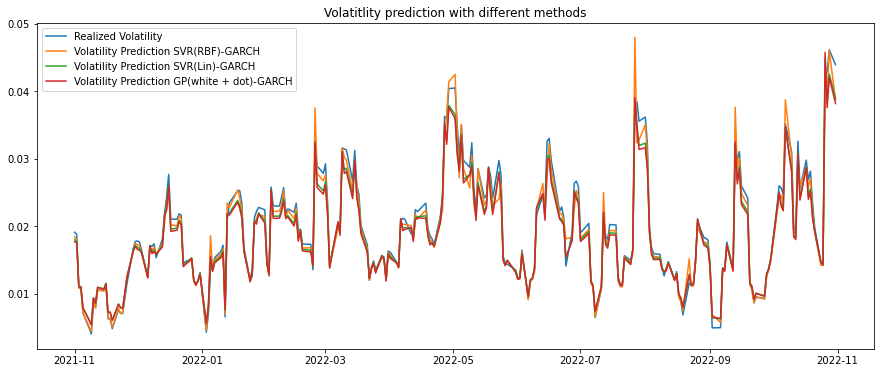

In [136]:
realized_vol.index = ret.iloc[4:].index
plt.figure(figsize=(15, 6))
plt.plot(realized_vol[-pred_gp.size:]/100, label = 'Realized Volatility')
plt.plot(pred_svr_rbf/100, label = 'Volatility Prediction SVR(RBF)-GARCH')
plt.plot(pred_svr_lin/100, label = 'Volatility Prediction SVR(Lin)-GARCH')
plt.plot(pred_gp/100, label = 'Volatility Prediction GP(white + dot)-GARCH')
plt.title('Volatitlity prediction with different methods', fontsize=12)
plt.legend()
plt.show()